# PanAntarctic comparison for  DSW export

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import gsw
from pathlib import Path

import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.path as mpath
from IPython.display import display, Image

import netCDF4 as nc
import xarray as xr
import numpy as np
import xgcm
import calendar

from matplotlib import gridspec
from collections import OrderedDict

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33819/status,
Dashboard: /proxy/33819/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35615,Workers: 0
Dashboard: /proxy/33819/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35395,Total threads: 1
Dashboard: /proxy/38793/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:37517,


In [4]:
# Contour mask
isobath_depth = 1000
outfile = '/g/data/ik11/grids'+'/Antarctic_slope_contour_'+str(isobath_depth)+'m_MOM6_005deg.nc'
contour_mask = xr.open_dataset(outfile)

### Loading the data 

In [5]:
# had to change this bc of contour files
lat_slice = slice(-79,-59)

In [6]:
# Importing data
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [7]:
# Time variant variables
def preprocess(ds):
    ds = ds[['uo','vo','agessc','so']] # Picking out variables get all grids
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

### From contour mask

In [9]:
# Load grid variables
yh = cont['yh'].sel(yh=lat_slice)
yq = cont['yq'].sel(yq=lat_slice)
xh = cont['xh']
xq = cont['xq']
deptho = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['deptho'].sel(yh=lat_slice)

In [10]:
mask_y_transport = contour_mask['mask_y_transport'].sel(yq=lat_slice)
mask_x_transport = contour_mask['mask_x_transport'].sel(yh=lat_slice)
mask_y_transport_numbered = contour_mask['mask_y_transport_numbered'].sel(yq=lat_slice)
mask_x_transport_numbered = contour_mask['mask_x_transport_numbered'].sel(yh=lat_slice)

In [11]:
mask_x_transport = xr.DataArray(mask_x_transport, coords = [yh, xq[:-1]], dims=['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yq[:-1], xh], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yh, xq[:-1]], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yq[:-1], xh], dims=['y_ocean', 'x_ocean'])

In [12]:
# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)

In [13]:
# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean
# don't need the multi-index anymore, replace with contour count
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

### Transport cumulative sums for different density classes and sectors

In [14]:
# If already loaded, just use:
distance_along_contour_01 = xr.open_dataset('/g/data/x77/kc5856/Post_Process/panan-01/1000m_isobath_contour_distance.nc').distance_along_contour
distance_along_contour_005 = xr.open_dataset('/g/data/x77/kc5856/Post_Process/panan-005/1000m_isobath_contour_distance.nc').distance_along_contour

In [15]:
#determine where to put lon tick marks
distance_indices = np.zeros(8)
for i in np.arange(100,len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
distance_indices[7] = len(lon_along_contour.contour_index.values)-1

In [16]:
# Define in longitude space what the cut-off values for regions should be.
AdelieW = -280
AdelieE = -200
RossW = -200
RossE = -150
# WAW = -150
# WAE = -65
AmW = -150
AmE = -100
BeW = -100
BeE = -65

WeddellW = -65
WeddellE = 0
PrydzW = 0
PrydzE = 80

In [17]:
# Find corresponding contour indices for sectors
basin_indices = np.zeros(7)
for i in np.arange(100,len(lon_along_contour.values)):
    if (basin_indices[1]==0):
        if (lon_along_contour.values[i]>AdelieE):
            basin_indices[1] = lon_along_contour.contour_index.values[i]
    if (basin_indices[2]==0):
        if (lon_along_contour.values[i]>RossE):
            basin_indices[2] = lon_along_contour.contour_index.values[i]
    if (basin_indices[3]==0):
        if (lon_along_contour.values[i]>AmE):
            basin_indices[3] = lon_along_contour.contour_index.values[i]
    if (basin_indices[4]==0):
        if (lon_along_contour.values[i]>BeE):
            basin_indices[4] = lon_along_contour.contour_index.values[i]
    if (basin_indices[5]==0):
        if lon_along_contour.values[i]>WeddellE:
            basin_indices[5] = lon_along_contour.contour_index.values[i]
    if (basin_indices[6]==0):
        if (lon_along_contour.values[i]>PrydzE):
            basin_indices[6] = lon_along_contour.contour_index.values[i]
basin_indices

array([   0., 2381., 4125., 5451., 6522., 9627.,    0.])

In [18]:
Adelie = slice(basin_indices[0],basin_indices[1])
Ross = slice(basin_indices[1],basin_indices[2])
Am = slice(basin_indices[2],basin_indices[3])
Be = slice(basin_indices[3],basin_indices[4])
Weddell = slice(basin_indices[4], basin_indices[5])
Prydz = slice(basin_indices[5],12004)

## Plotting

In [19]:
land_mask = np.squeeze(deptho.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = deptho.yh.values
land_mask_lat[0] = -90

In [20]:
# Define paths
grid_path = '/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc'
save_dir = '/g/data/x77/kc5856/sofia-cross_slope_transport/cross_slope_binned/'

# Load grid
grid = xr.open_dataset(grid_path)
deptho = grid['deptho'].sel(yh=lat_slice)
yh = grid['yh'].sel(yh=lat_slice)
xh = grid['xh']

In [21]:
file_dir = '/g/data/x77/kc5856/sofia-cross_slope_transport/plots/'

In [24]:
pan01_cont_circ = xr.open_dataset(file_dir+'Circumpolar_Control_pan01_transport_profile.nc').to_array().squeeze()
pan01_cont_Ade = xr.open_dataset(file_dir+'Adelie_Control_pan01_transport_profile.nc').to_array().squeeze()
pan01_cont_Ros = xr.open_dataset(file_dir+'Ross_Control_pan01_transport_profile.nc').to_array().squeeze()
pan01_cont_Am = xr.open_dataset(file_dir+'Amundsen_Control_pan01_transport_profile.nc').to_array().squeeze()
pan01_cont_Be = xr.open_dataset(file_dir+'Bellingshausen_Control_pan01_transport_profile.nc').to_array().squeeze()
pan01_cont_We = xr.open_dataset(file_dir+'Weddell_Control_pan01_transport_profile.nc').to_array().squeeze()
pan01_cont_Pr = xr.open_dataset(file_dir+'Prydz_Control_pan01_transport_profile.nc').to_array().squeeze()

pan01_melt_circ = xr.open_dataset(file_dir+'Circumpolar_Melt_pan01_transport_profile.nc').to_array().squeeze()
pan01_melt_Ade = xr.open_dataset(file_dir+'Adelie_Melt_pan01_transport_profile.nc').to_array().squeeze()
pan01_melt_Ros = xr.open_dataset(file_dir+'Ross_Melt_pan01_transport_profile.nc').to_array().squeeze()
pan01_melt_Am = xr.open_dataset(file_dir+'Amundsen_Melt_pan01_transport_profile.nc').to_array().squeeze()
pan01_melt_Be = xr.open_dataset(file_dir+'Bellingshausen_Melt_pan01_transport_profile.nc').to_array().squeeze()
pan01_melt_We = xr.open_dataset(file_dir+'Weddell_Melt_pan01_transport_profile.nc').to_array().squeeze()
pan01_melt_Pr = xr.open_dataset(file_dir+'Prydz_Melt_pan01_transport_profile.nc').to_array().squeeze()

In [25]:
pan005_cont_circ = xr.open_dataset(file_dir+'Circumpolar_Control_pan005_transport_profile.nc').to_array().squeeze()
pan005_cont_Ade = xr.open_dataset(file_dir+'Adelie_Control_pan005_transport_profile.nc').to_array().squeeze()
pan005_cont_Ros = xr.open_dataset(file_dir+'Ross_Control_pan005_transport_profile.nc').to_array().squeeze()
pan005_cont_Am = xr.open_dataset(file_dir+'Amundsen_Control_pan005_transport_profile.nc').to_array().squeeze()
pan005_cont_Be = xr.open_dataset(file_dir+'Bellingshausen_Control_pan005_transport_profile.nc').to_array().squeeze()
pan005_cont_We = xr.open_dataset(file_dir+'Weddell_Control_pan005_transport_profile.nc').to_array().squeeze()
pan005_cont_Pr = xr.open_dataset(file_dir+'Prydz_Control_pan005_transport_profile.nc').to_array().squeeze()

pan005_melt_circ = xr.open_dataset(file_dir+'Circumpolar_Melt_pan005_transport_profile.nc').to_array().squeeze()
pan005_melt_Ade = xr.open_dataset(file_dir+'Adelie_Melt_pan005_transport_profile.nc').to_array().squeeze()
pan005_melt_Ros = xr.open_dataset(file_dir+'Ross_Melt_pan005_transport_profile.nc').to_array().squeeze()
pan005_melt_Am = xr.open_dataset(file_dir+'Amundsen_Melt_pan005_transport_profile.nc').to_array().squeeze()
pan005_melt_Be = xr.open_dataset(file_dir+'Bellingshausen_Melt_pan005_transport_profile.nc').to_array().squeeze()
pan005_melt_We = xr.open_dataset(file_dir+'Weddell_Melt_pan005_transport_profile.nc').to_array().squeeze()
pan005_melt_Pr = xr.open_dataset(file_dir+'Prydz_Melt_pan005_transport_profile.nc').to_array().squeeze()

In [26]:
pan01_anom_circ = pan01_melt_circ - pan01_cont_circ
pan01_anom_Ade = pan01_melt_Ade - pan01_cont_Ade
pan01_anom_Ros = pan01_melt_Ros - pan01_cont_Ros
pan01_anom_Am = pan01_melt_Am - pan01_cont_Am
pan01_anom_Be = pan01_melt_Be - pan01_cont_Be
pan01_anom_We = pan01_melt_We - pan01_cont_We
pan01_anom_Pr = pan01_melt_Pr - pan01_cont_Pr

In [27]:
pan005_anom_circ = pan005_melt_circ - pan005_cont_circ
pan005_anom_Ade = pan005_melt_Ade - pan005_cont_Ade
pan005_anom_Ros = pan005_melt_Ros - pan005_cont_Ros
pan005_anom_Am = pan005_melt_Am - pan005_cont_Am
pan005_anom_Be = pan005_melt_Be - pan005_cont_Be
pan005_anom_We = pan005_melt_We - pan005_cont_We
pan005_anom_Pr = pan005_melt_Pr - pan005_cont_Pr

In [28]:
# Cumulative sums
pan01_cont_cumsum = xr.open_dataset(file_dir+'Control_pan01_cumulative_transport.nc')['Control_cumulative_transport']
pan01_melt_cumsum = xr.open_dataset(file_dir+'Melt_pan01_cumulative_transport.nc')['Melt_cumulative_transport']
pan01_anom_cumsum = pan01_melt_cumsum - pan01_cont_cumsum

pan005_cont_cumsum = xr.open_dataset(file_dir+'Control_pan005_cumulative_transport.nc')['Control_cumulative_transport']
pan005_melt_cumsum = xr.open_dataset(file_dir+'Melt_pan005_cumulative_transport.nc')['Melt_cumulative_transport']
pan005_anom_cumsum = pan005_melt_cumsum - pan005_cont_cumsum

In [45]:
distance_along_contour_01

<xarray.DataArray 'distance_along_contour' (distance_along_contour: 6052)> Size: 48kB
array([3.255779e-03, 6.511559e-03, 1.102909e-02, ..., 2.101659e+01,
       2.101984e+01, 2.102436e+01])
Coordinates:
  * distance_along_contour  (distance_along_contour) float64 48kB 0.003256 .....

In [38]:
pan01_anom_cumsum

<xarray.DataArray (contour_index: 6052)> Size: 48kB
array([ 0.01252956, -0.01723597, -0.0050257 , ..., -0.92189074,
       -0.99725005, -0.94969619])
Coordinates:
    rho2_l         float64 8B 1.016e+03
  * contour_index  (contour_index) int64 48kB 1 2 3 4 5 ... 6049 6050 6051 6052

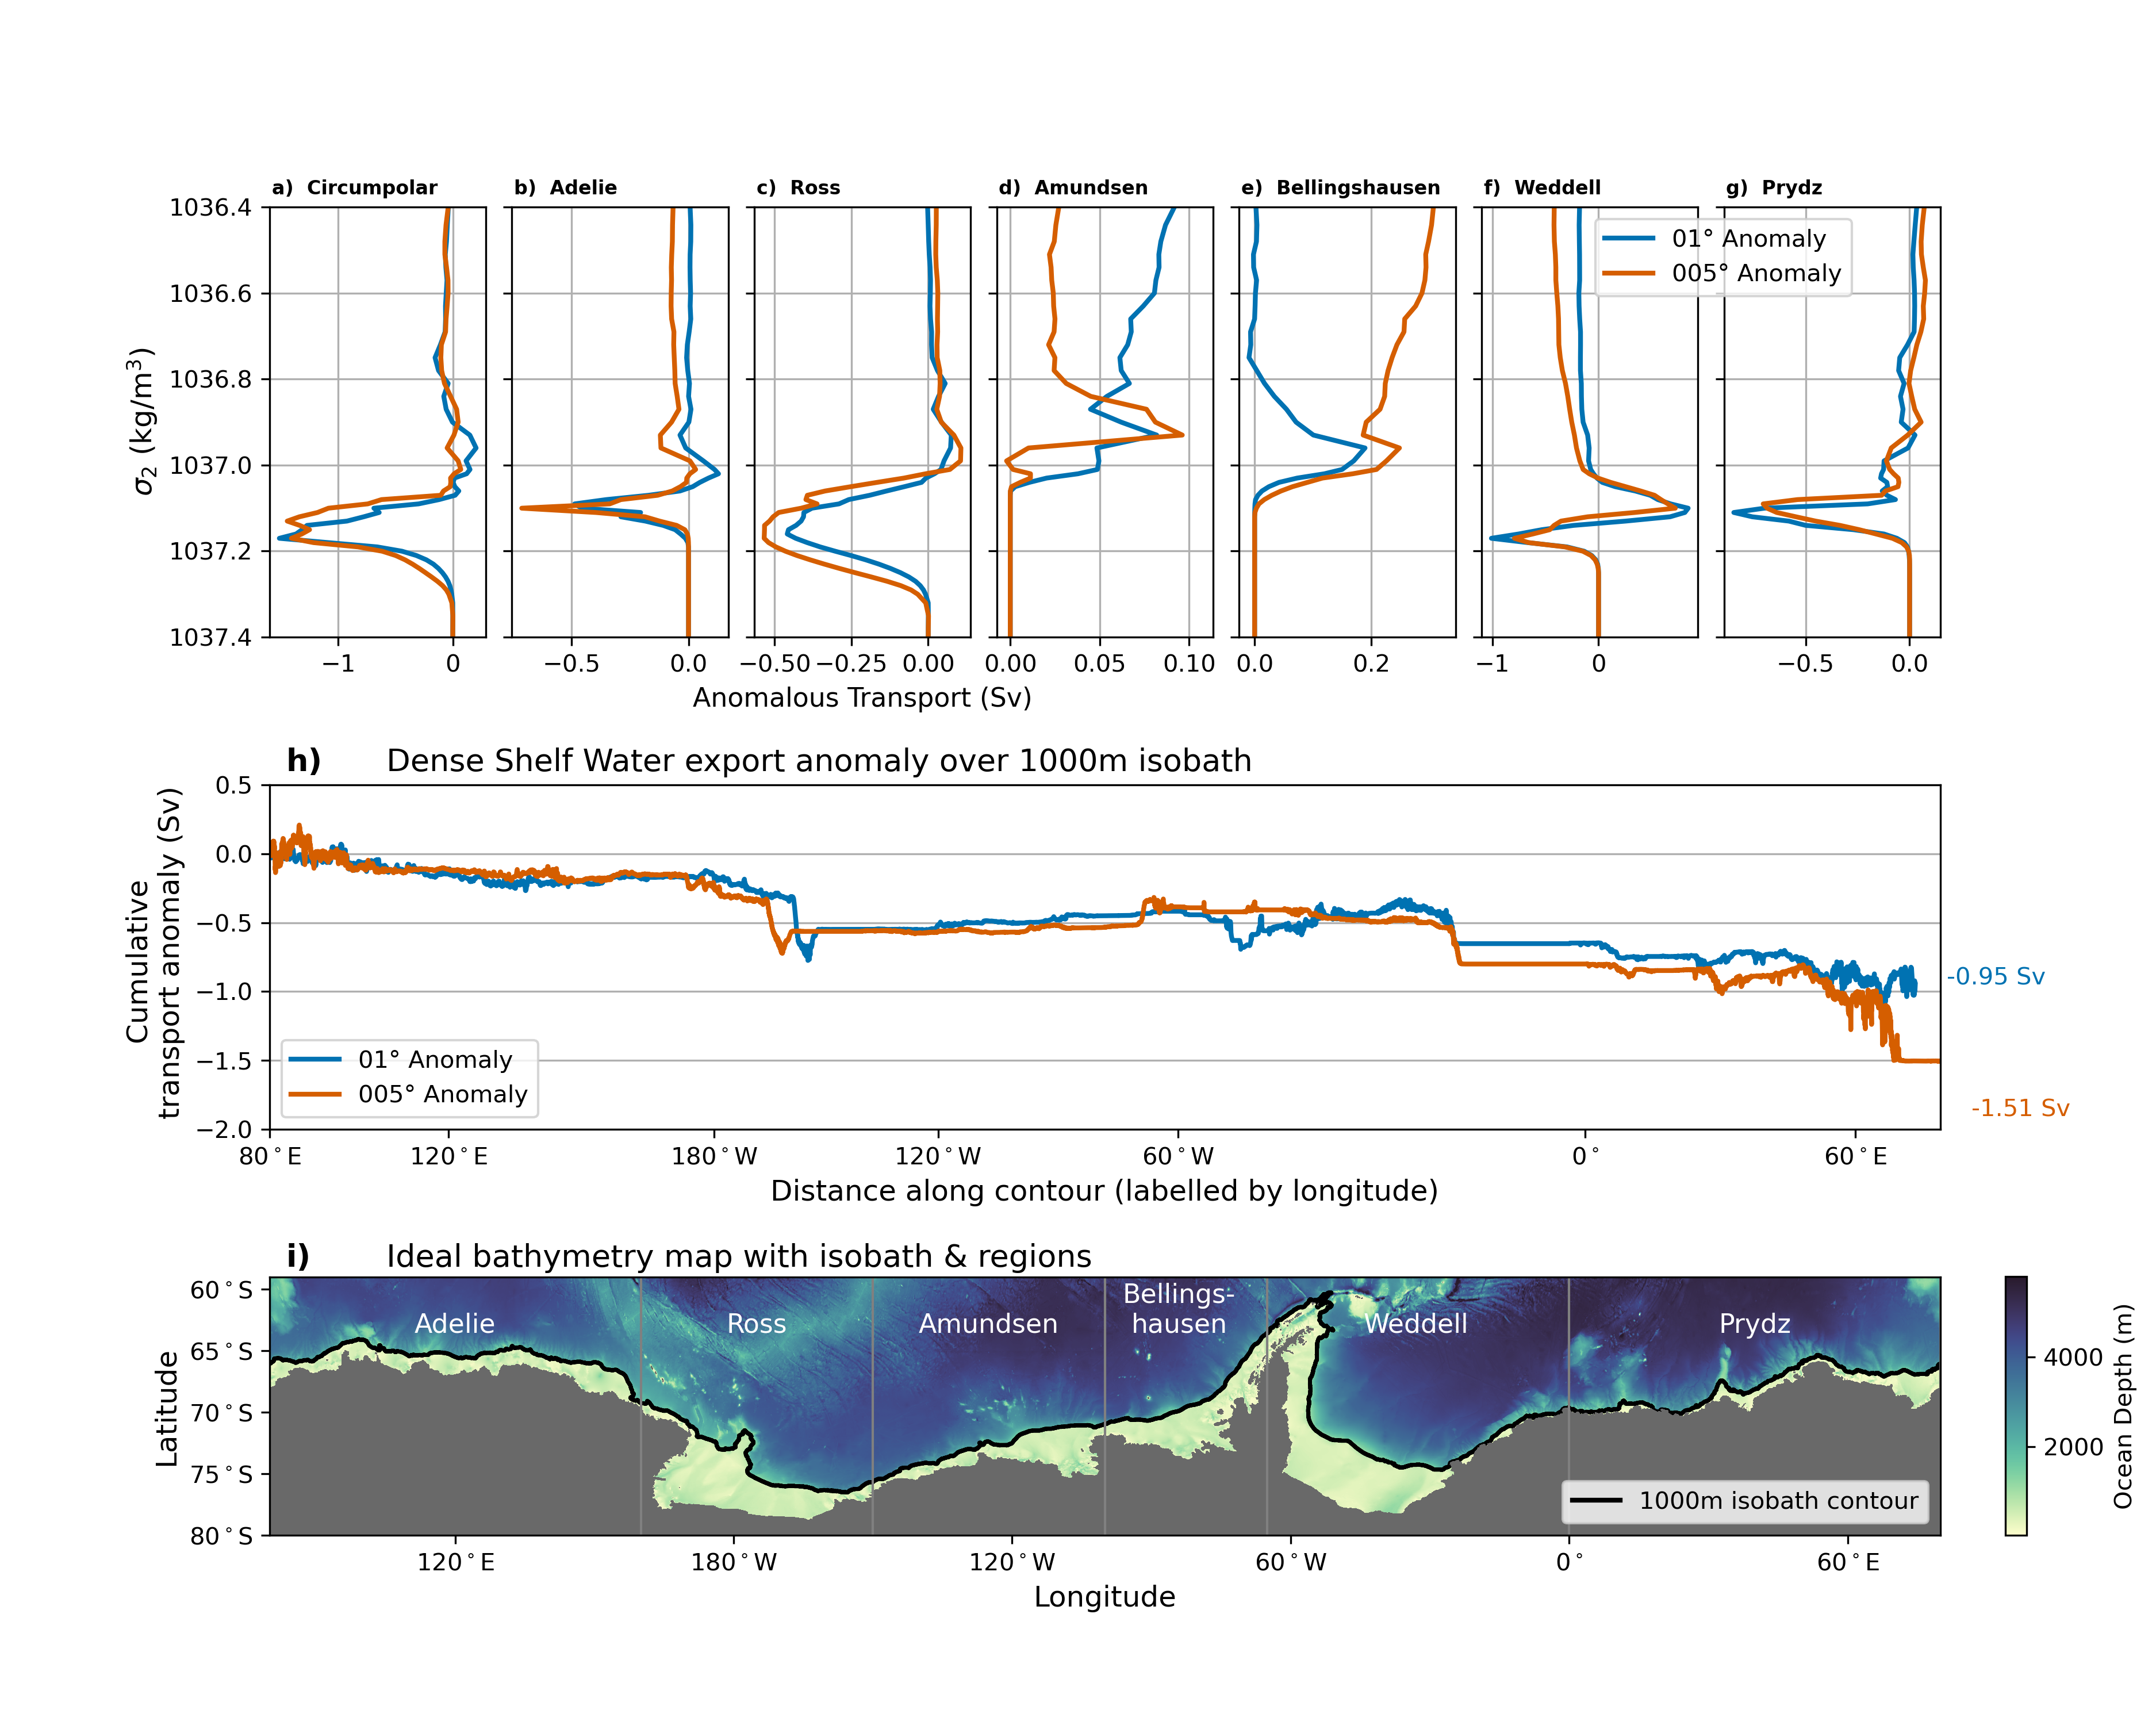

In [55]:
# --- Plotting configuration ---
colors = {'pan01': '#0072B2', 'pan005': '#D55E00'}
linestyles = {'pan01': '-', 'pan005': '-'}
linewidths = {'pan01': 2, 'pan005': 2}
labels = {'pan01': '01° Anomaly', 'pan005': '005° Anomaly'}

# --- Define figure and subplots ---
gs = gridspec.GridSpec(3, 7, height_ratios=[1, 0.8, 0.6])
fig = plt.figure(figsize=(12.5, 10), dpi=300)
ax0, ax1, ax2, ax3, ax4, ax4b, ax5, ax6, ax7 = (
    plt.subplot(gs[2, :]), plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1]), plt.subplot(gs[0, 2]),
    plt.subplot(gs[0, 3]), plt.subplot(gs[0, 4]), plt.subplot(gs[0, 5]), plt.subplot(gs[0, 6]),
    plt.subplot(gs[1, :])
)

# --- Bathymetry Plot (ax0) ---
h_plot = deptho.plot(ax=ax0, cmap=cm.cm.deep, add_colorbar=False)
cax = plt.axes([0.93, 0.11, 0.01, 0.15])
plt.colorbar(h_plot, cax=cax, label='Ocean Depth (m)')

ax0.contour(xh, yh, np.abs(mask_x_transport.values) + np.abs(mask_y_transport.values), colors='k')
ax0.contourf(deptho.xh, land_mask_lat, land_mask_masked, colors='dimgrey', zorder=2)
ax0.vlines([-280, -200, -150, -100, -65, 0, 80], -82, -58, color='grey', linewidth=1)

region_labels = ['Adelie', 'Ross', 'Amundsen', 'Bellings-\nhausen', 'Weddell', 'Prydz']
region_lons = [-240, -175, -125, -84, -33, 40]
for x, name in zip(region_lons, region_labels):
    ax0.text(x, -64, name, ha='center', va='bottom', fontsize=11, color='w')

ax0.plot([0, 1], [0, 1], color='k', linewidth=2, label='1000m isobath contour')  # dummy legend
ax0.legend(loc='lower right')
ax0.set_ylabel('Latitude', fontsize=12)
ax0.set_xlabel('Longitude', fontsize=12)
ax0.set_ylim(min(yh.values), max(yh.values))
ax0.set_xticks([-240, -180, -120, -60, 0, 60])
ax0.set_xticklabels(('120$^\circ$E', '180$^\circ$W', '120$^\circ$W', '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
ax0.set_yticks([-80, -75, -70, -65, -60])
ax0.set_yticklabels(('80$^\circ$S', '75$^\circ$S', '70$^\circ$S', '65$^\circ$S', '60$^\circ$S'))
ax0.text(0.01, 1.04, 'i)', fontsize=13, fontweight='bold', transform=ax0.transAxes)
ax0.text(0.07, 1.04, 'Ideal bathymetry map with isobath & regions', fontsize=13, transform=ax0.transAxes)

# --- Sector anomaly names and arrays ---
sector_names = ['Circumpolar', 'Adelie', 'Ross', 'Amundsen', 'Bellingshausen', 'Weddell', 'Prydz']
letter_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)']

sector_anoms_01 = [
    pan01_anom_circ, pan01_anom_Ade, pan01_anom_Ros, pan01_anom_Am,
    pan01_anom_Be, pan01_anom_We, pan01_anom_Pr
]

sector_anoms_005 = [
    pan005_anom_circ, pan005_anom_Ade, pan005_anom_Ros, pan005_anom_Am,
    pan005_anom_Be, pan005_anom_We, pan005_anom_Pr
]

# --- Plot sector anomalies on top row ---
for n, (ax, name, letter, array_01, array_005) in enumerate(zip(
        [ax1, ax2, ax3, ax4, ax4b, ax5, ax6],
        sector_names, letter_labels, sector_anoms_01, sector_anoms_005)):

    for key, array in zip(['pan01', 'pan005'], [array_01, array_005]):
        array.plot(ax=ax, y='rho2_l', label=labels[key], color=colors[key],
                   linestyle=linestyles[key], linewidth=linewidths[key])

    ax.set_ylim(1037.4, 1036.4)
    ax.grid()
    ax.set_title('')
    ax.text(0.01, 1.03, f'{letter}  {name}', transform=ax.transAxes,
            fontsize=8, fontweight='bold')

    if n == 0:
        ax.set_ylabel('$\sigma_2$ (kg/m$^3$)', fontsize=12)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])

    if n == 2:
        ax.set_xlabel('Anomalous Transport (Sv)', fontsize=11)
    else:
        ax.set_xlabel('')

    if n == 6:
        ax.legend(loc='upper left', bbox_to_anchor=(-0.65, 1), fontsize=10)

# --- Dictionary for distance arrays ---
distance_dict = {
    'pan01': distance_along_contour_01,
    'pan005': distance_along_contour_005,
}

# --- Plot cumulative transport anomalies (bottom subplot ax7) ---
for key, array in zip(['pan01', 'pan005'], [pan01_anom_cumsum, pan005_anom_cumsum]):
    offset = 0 if key == 'pan01' else -0.4
    xvals = distance_dict[key]
    array = array
    ax7.plot(xvals, array, label=labels[key],
             color=colors[key], linestyle=linestyles[key], linewidth=linewidths[key])
    ax7.text(xvals[-1] + 0.4, offset + array[-1],
             f"{array[-1]:.2f} Sv", color=colors[key], fontsize=10)
    
ax7.set_ylabel('Cumulative \n transport anomaly (Sv)', fontsize=12)
valid_indices = distance_indices[distance_indices < len(distance_along_contour_005)].astype(int)
ax7.set_xticks(distance_along_contour_005[valid_indices[:-1]])
ax7.set_xticklabels(('80$^\circ$E', '120$^\circ$E', '180$^\circ$W',
                    '120$^\circ$W', '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
ax7.set_xlim(0, max(distance_along_contour_01[-1], distance_along_contour_005[-1]))
ax7.set_ylim(-2, 0.5)
ax7.grid(axis='y')
ax7.set_xlabel('Distance along contour (labelled by longitude)', fontsize=12)
ax7.legend(loc='lower left', bbox_to_anchor=(0, 00), fontsize=10)
ax7.text(0.01, 1.04, 'h)', fontsize=13, fontweight='bold', transform=ax7.transAxes)
ax7.text(0.07, 1.04, 'Dense Shelf Water export anomaly over 1000m isobath',
         fontsize=13, transform=ax7.transAxes)

# --- Final layout adjustment and save ---
fig.subplots_adjust(hspace=0.43, wspace=0.12)
fig.savefig("pan01_vs_pan005_anomaly_comparison.png", dpi=300)
plt.close(fig)
display(Image(filename="pan01_vs_pan005_anomaly_comparison.png", width=1200))


In [51]:
distance_along_contour_005[-1]

<xarray.DataArray 'distance_along_contour' ()> Size: 8B
array(21.34529865)
Coordinates:
    distance_along_contour  float64 8B 21.35

In [49]:
max(distance_along_contour_01[-1], distance_along_contour_005[-1])

<xarray.DataArray 'distance_along_contour' ()> Size: 8B
array(21.34529865)
Coordinates:
    distance_along_contour  float64 8B 21.35

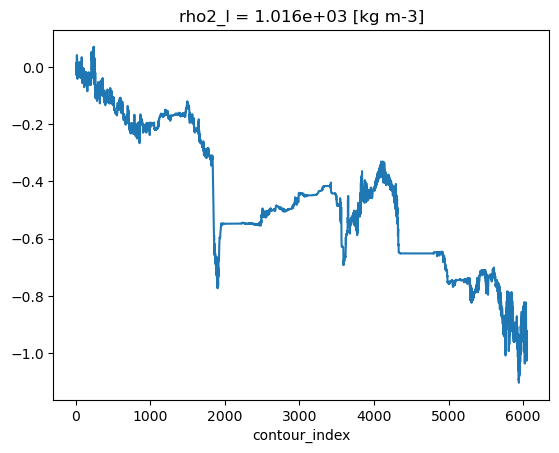

In [30]:
pan01_anom_cumsum.plot()

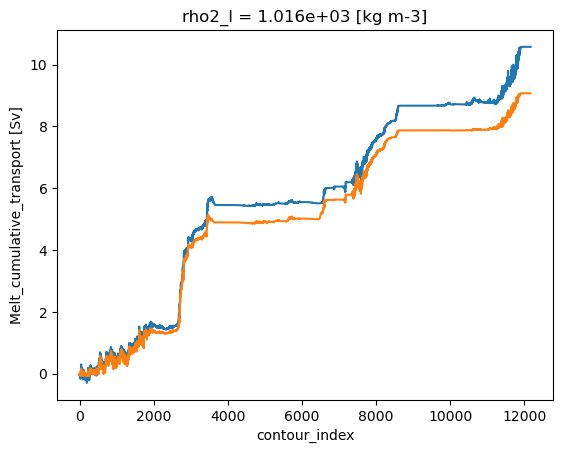

In [31]:
pan005_cont_cumsum.plot()
pan005_melt_cumsum.plot()

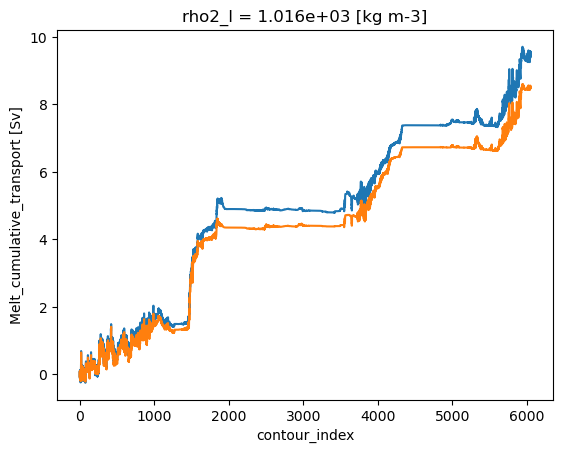

In [32]:
pan01_cont_cumsum.plot()
pan01_melt_cumsum.plot()